In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded=files.upload()

Saving appointments_updated.csv to appointments_updated.csv


In [3]:
import io
df=pd.read_csv(io.BytesIO(uploaded['appointments_updated.csv']))
df=df.fillna("NULL")
print(df)


                                             id  ...                   query_value
0      119cc56861f3e602654b325802c4e373d89c8d25  ...  ophthalmologist/ eye surgeon
1      4d2dc045f02d7b59988a1edcf9c6cef09cee18fe  ...               Ophthalmologist
2      655188d31614f9757da766e4e9be61ebd2ec408b  ...  ophthalmologist/ eye surgeon
3      44c395026f72db339eb32cdc223935444033df44  ...               Ophthalmologist
4      cf481ac856902648b79a3a15060937b47bf551e4  ...               plastic surgeon
...                                         ...  ...                           ...
76085  b01f8891e480ca333ff374db978bd63658220ccb  ...                       Dentist
76086  5e2b38e578100070132615d870156a6724ad2449  ...               physiotherapist
76087  49c21aa9dc7b83828e926f42193c35bc1c457988  ...             General Physician
76088  50f242e45421a9c85083cd8bd96f1af4106d8d08  ...             General Physician
76089  e568930c1ef85bc820d128d300d399d952d82528  ...                       Dentist

[76

In [4]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [5]:
#getting the month
def get_month(x): return dt.datetime(x.year, x.month, 1)

df['InMonth'] = df['created_at'].apply(get_month)
#cohort month : the first month for the specific patient ID when that patient booked its first appointment
grouping1 = df.groupby('patient_id')['InMonth']
df['CohortMonth'] = grouping1.transform('min')
print(df.describe())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


                                              id  ...          CohortMonth
count                                      76090  ...                76090
unique                                     76090  ...                    2
top     38023b39ca74dd45b339920411fcedb56ea42ce1  ...  2021-01-01 00:00:00
freq                                           1  ...                40046
first                                        NaN  ...  2020-12-01 00:00:00
last                                         NaN  ...  2021-01-01 00:00:00

[6 rows x 14 columns]


In [6]:
#function to extract year,month,day as integers
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
#extract month
in_year, in_month, _ = get_date_int(df, 'InMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

In [7]:
years_diff = in_year - cohort_year
months_diff = in_month - cohort_month

In [8]:
#cohort index : the month difference between booking month and cohort month for each row.
df['CohortIndex'] = years_diff * 12 + months_diff + 1
print(df.head())
dft=df.to_csv('useit.csv')

                                         id  ... CohortIndex
0  119cc56861f3e602654b325802c4e373d89c8d25  ...           1
1  4d2dc045f02d7b59988a1edcf9c6cef09cee18fe  ...           1
2  655188d31614f9757da766e4e9be61ebd2ec408b  ...           1
3  44c395026f72db339eb32cdc223935444033df44  ...           1
4  cf481ac856902648b79a3a15060937b47bf551e4  ...           1

[5 rows x 15 columns]


OVERALL RETENTION RATE CALCULATION

# in the o/p below :
row: represents users first transaction
col: represents no of users who booked an appointment


In [9]:
grouping_count = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['patient_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='patient_id')
print(cohort_counts)
dfs=cohort_counts.to_csv("file.csv")


CohortIndex        1      2
CohortMonth                
2020-12-01   34255.0  509.0
2021-01-01   38837.0    NaN


In [10]:
#calculate retention rate
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')
print(retention)
dfs1=retention.to_csv("file2.csv")


CohortIndex    1         2
CohortMonth               
12-2020      1.0  0.014859
01-2021      1.0       NaN


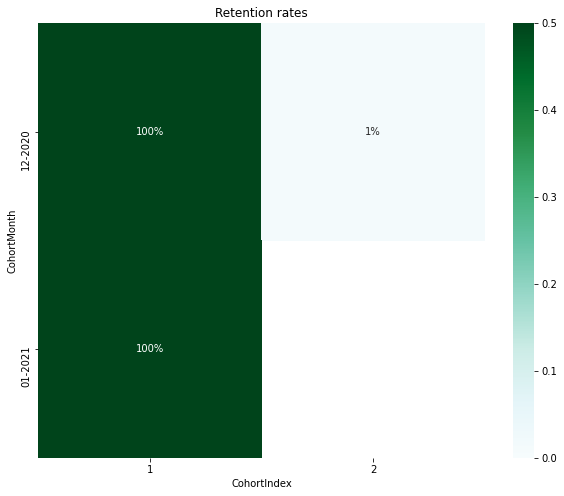

In [11]:
#plotting heatmap with seaborn for visualisation
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()


RETENTION RATE CALCULATION WHEN CITY=AHMEDABAD

(348, 15)
CohortIndex      1    2
CohortMonth            
2020-12-01   157.0  2.0
2021-01-01   179.0  NaN
CohortIndex    1         2
CohortMonth               
12-2020      1.0  0.012739
01-2021      1.0       NaN


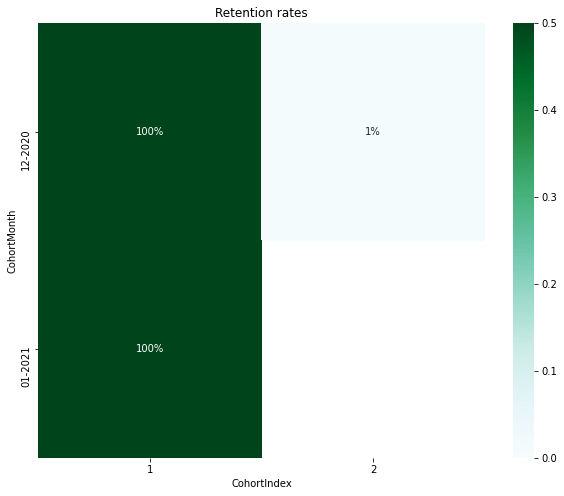

In [12]:
dfcitya = df[df['city']=='Ahmedabad']
print(dfcitya.shape)
grouping_count = dfcitya.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['patient_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='patient_id')
print(cohort_counts)

cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')
print(retention)

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()
dfs7=cohort_counts.to_csv("ahmdbr.csv")

RETENTION RATE CALCULATION WHEN SOURCE=ANDROID


(28048, 15)
CohortIndex        1      2
CohortMonth                
2020-12-01   12980.0  213.0
2021-01-01   13739.0    NaN
CohortIndex    1        2
CohortMonth              
12-2020      1.0  0.01641
01-2021      1.0      NaN


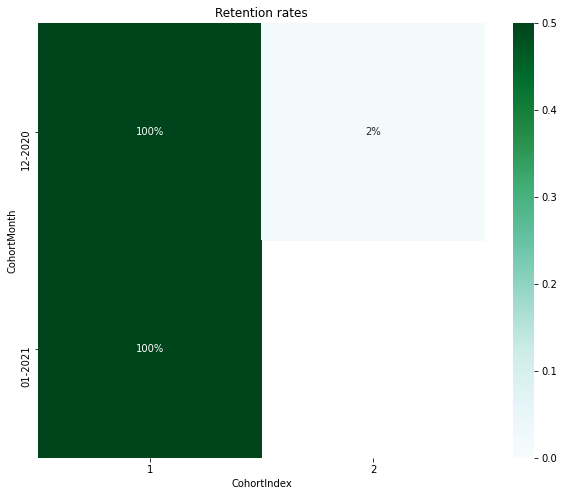

In [13]:
dfsource = df[df['source']=='android']
print(dfsource.shape)
grouping_count = dfsource.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['patient_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='patient_id')
print(cohort_counts)

cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')
print(retention)

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()
dfs11=cohort_counts.to_csv("androidr.csv")

RETENTION RATE CALCULATION WHEN SOURCE=IOS


(11930, 15)
CohortIndex       1      2
CohortMonth               
2020-12-01   5142.0  227.0
2021-01-01   5717.0    NaN
CohortIndex    1         2
CohortMonth               
12-2020      1.0  0.044146
01-2021      1.0       NaN


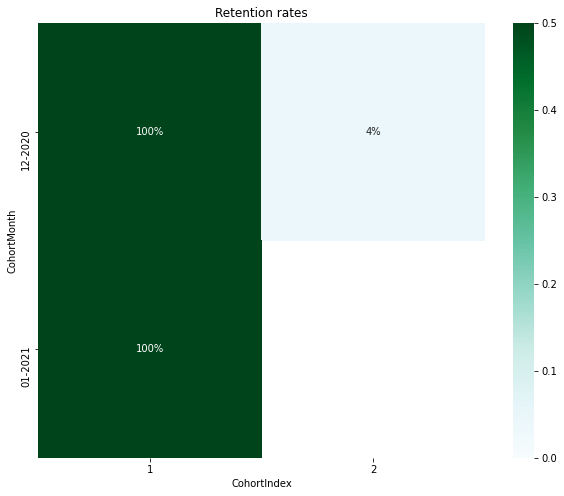

In [14]:
dfsource1 = df[df['source']=='iOS']
print(dfsource1.shape)
grouping_count = dfsource1.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['patient_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='patient_id')
print(cohort_counts)

cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')
print(retention)

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()
dfs12=cohort_counts.to_csv("iosr.csv")

RETENTION RATE CALCULATION WHEN SOURCE=MWEB

(36112, 15)
CohortIndex        1     2
CohortMonth               
2020-12-01   16156.0  72.0
2021-01-01   19410.0   NaN
CohortIndex    1         2
CohortMonth               
12-2020      1.0  0.004457
01-2021      1.0       NaN


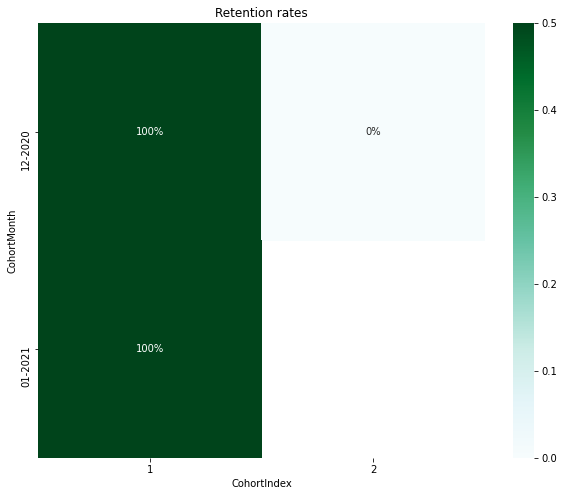

In [15]:
dfsource2 = df[df['source']=='mWeb']
print(dfsource2.shape)
grouping_count = dfsource2.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['patient_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='patient_id')
print(cohort_counts)

cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')
print(retention)

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()
dfs13=cohort_counts.to_csv("mwebr.csv")

RETENTION RATE CALCULATION WHEN STATUS=CONFIRMED

(59272, 15)
CohortIndex        1      2
CohortMonth                
2020-12-01   27177.0  426.0
2021-01-01   30469.0    NaN
CohortIndex    1         2
CohortMonth               
12-2020      1.0  0.015675
01-2021      1.0       NaN


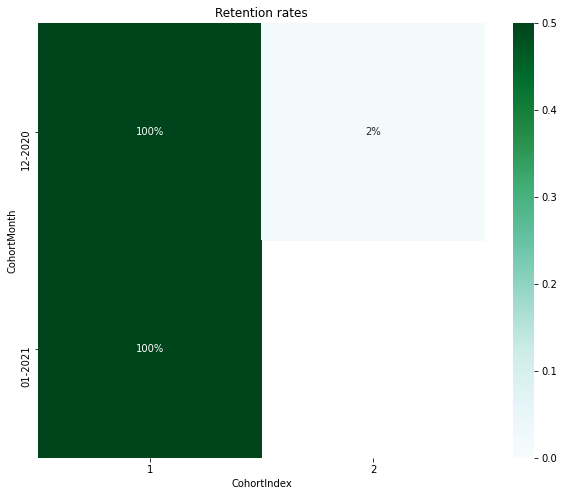

In [16]:
dfstatus = df[df['status']=='CONFIRMED']
print(dfstatus.shape)
grouping_count = dfstatus.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['patient_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='patient_id')
print(cohort_counts)

cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')
print(retention)

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()

dfs10=cohort_counts.to_csv("confretention.csv")

RETENTION RATE CALCULATION WHEN CITY=BANGALORE


(19954, 15)
CohortIndex        1      2
CohortMonth                
2020-12-01    8771.0  169.0
2021-01-01   10212.0    NaN
CohortIndex    1         2
CohortMonth               
12-2020      1.0  0.019268
01-2021      1.0       NaN


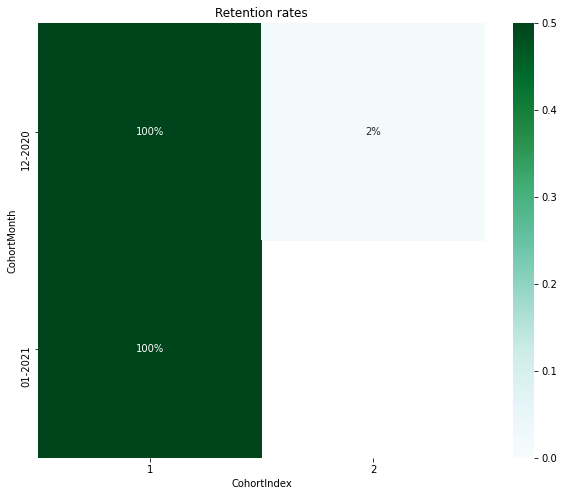

In [17]:
dfcityb = df[df['city']=='Bangalore']
print(dfcityb.shape)
grouping_count = dfcityb.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['patient_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='patient_id')
print(cohort_counts)

cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')
print(retention)

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()

RETENTION RATE CALCULATION WHEN CITY=GURGAON


(6863, 15)
CohortIndex       1     2
CohortMonth              
2020-12-01   3099.0  63.0
2021-01-01   3391.0   NaN
CohortIndex    1         2
CohortMonth               
12-2020      1.0  0.020329
01-2021      1.0       NaN


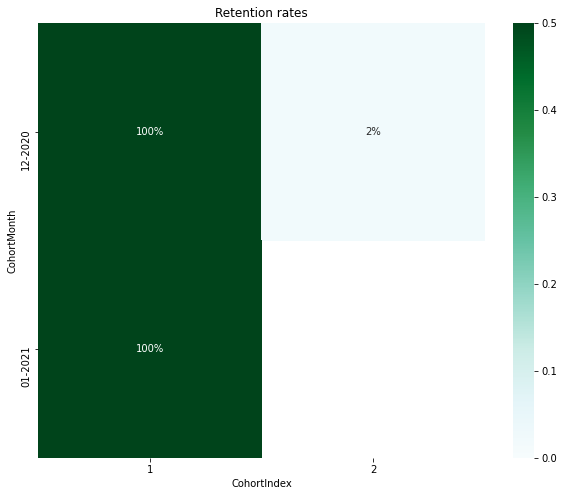

In [18]:
dfcityg = df[df['city']=='Gurgaon']
print(dfcityg.shape)
grouping_count = dfcityg.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['patient_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='patient_id')
print(cohort_counts)

cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')
print(retention)

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()